
Model                | Recursive R²    | Recursive RMSE  | Sensitivity    
--------------------------------------------------------------------------------
V1                   | 0.9347          | 0.0596          | 0.00%
V2                   | 0.9315          | 0.0610          | 0.00%
V3                   | 0.8894          | 0.0775          | 8.27%
V4                   | 0.7543          | 0.1156          | 3.28%
V5                   | 0.9466          | 0.0539          | 17.01%
V6                   | 0.9467          | 0.0538          | 15.01%
V7                   | 0.9440          | 0.0552          | 7.19%


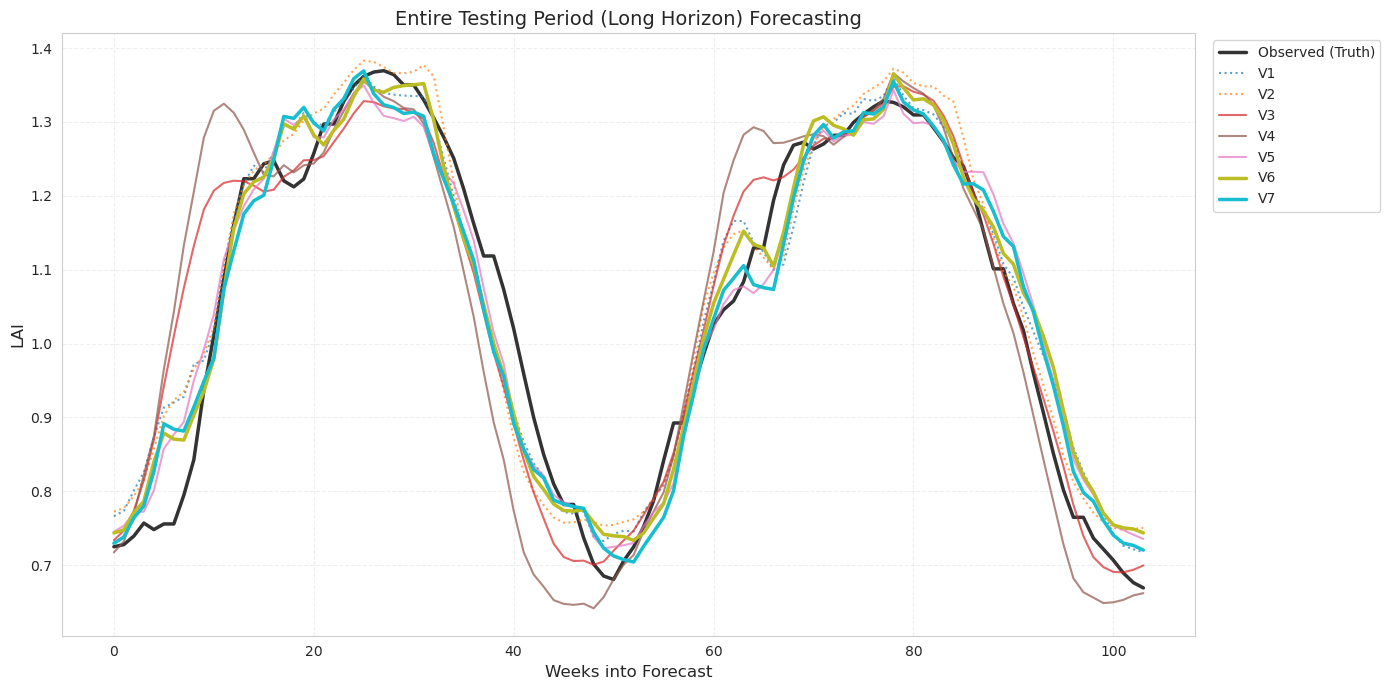

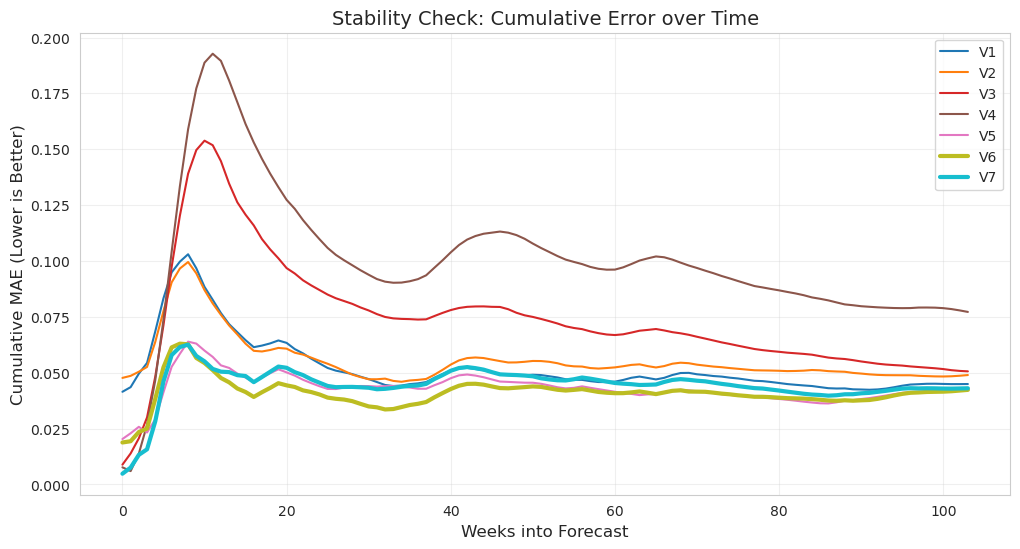

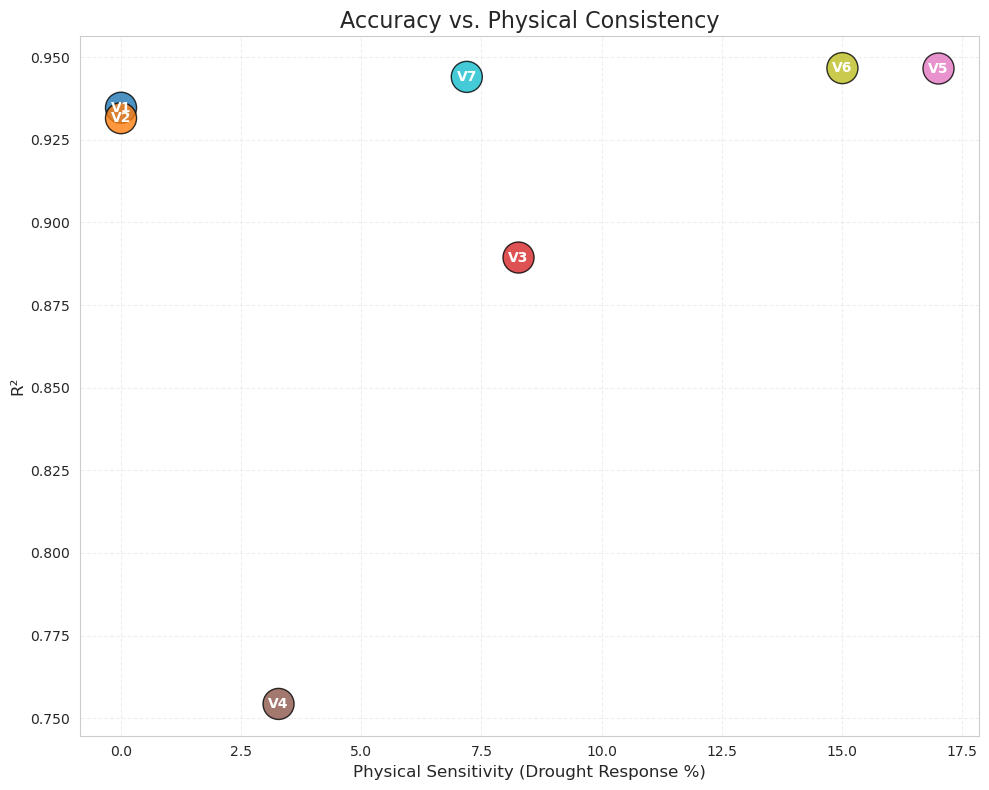

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import warnings

# ==========================================
# 0. Setup & Config
# ==========================================
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

CSV_FILE = 'master_data_for_all_models_weekly.csv'
TARGET_COL = 'LAI'
SEQ_LENGTH = 12
TRAIN_END_DATE = '2018-12-31'
TEST_START_DATE = '2019-01-01'
BATCH_SIZE = 16

CLIMATE_FEATURES = [
    "total_precipitation", 
    "volumetric_soil_water_layer_1", 
    "volumetric_soil_water_layer_2",
    "2m_temperature", 
    "surface_solar_radiation_downwards", 
    "evaporation", 
    "specific_humidity"
]

TIME_FEATURES = ['month_sin', 'month_cos']
LAG_FEATURE = ['LAI_lag_1']

F_BASE = CLIMATE_FEATURES                     # V1, V2, V7 (Pure Climate)
F_LAG = CLIMATE_FEATURES + LAG_FEATURE        # V3
F_CLIM_ONLY = CLIMATE_FEATURES + TIME_FEATURES # V5 (No lag)
F_FULL = CLIMATE_FEATURES + LAG_FEATURE + TIME_FEATURES # V4

# V6 
F_V6_ORDERED = CLIMATE_FEATURES + LAG_FEATURE + TIME_FEATURES 
V6_CLIMATE_DIM = len(CLIMATE_FEATURES)
V6_INERTIA_DIM = len(LAG_FEATURE) + len(TIME_FEATURES)

# ==========================================
# 1. Utilities
# ==========================================
class EarlyStopping:
    def __init__(self, patience=15, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_weights = copy.deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_weights = copy.deepcopy(model.state_dict())
            self.counter = 0

def process_data(df):
    # Time features
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    # Lag features
    df['LAI_lag_1'] = df['LAI'].shift(1)
    return df.dropna()

def create_sequences(features, targets, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        xs.append(features[i:(i + seq_length)])
        ys.append(targets[i + seq_length])
    return np.array(xs), np.array(ys)

def get_data_loaders(df, features, target_col):
    df_train = df.loc[:TRAIN_END_DATE]
    
    scaler_x = MinMaxScaler().fit(df_train[features].values)
    scaler_y = MinMaxScaler().fit(df_train[[target_col]].values)
    
    X_train = scaler_x.transform(df_train[features].values)
    y_train = scaler_y.transform(df_train[[target_col]].values)
    
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LENGTH)
    
    raw_X = df[features].values
    raw_y = df[[target_col]].values
    test_start_idx = np.where(df.index >= TEST_START_DATE)[0][0]
    
    # Extend test set to include lookback period
    X_test_ext = scaler_x.transform(raw_X[test_start_idx - SEQ_LENGTH : ])
    y_test_ext = scaler_y.transform(raw_y[test_start_idx - SEQ_LENGTH : ])
    
    X_test_seq, _ = create_sequences(X_test_ext, y_test_ext, SEQ_LENGTH)
    
    train_ds = TensorDataset(torch.from_numpy(X_train_seq).float(), torch.from_numpy(y_train_seq).float())
    loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    X_test_tensor = torch.from_numpy(X_test_seq).float()
    y_test_tensor_scaled = torch.from_numpy(y_test_ext[SEQ_LENGTH:]).float()
    
    return loader, X_test_tensor, y_test_tensor_scaled, scaler_x, scaler_y

# ==========================================
# 2. Model Definitions
# ==========================================
class LSTM_Base(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, 1, batch_first=True)
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_Stacked(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, 2, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_V3(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, 2, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_Robust(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, 1, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 1))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class LSTM_DualStream_V6(nn.Module):
    def __init__(self, input_dim, climate_dim, lag_dim, dropout_rate=0.5):
        super(LSTM_DualStream_V6, self).__init__()
        # Stream 1: Climate (Physics)
        self.lstm_climate = nn.LSTM(climate_dim, hidden_size=32, num_layers=1, batch_first=True)
        
        # Stream 2: Inertia (Memory)
        self.fc_inertia = nn.Sequential(nn.Linear(lag_dim, 32), nn.ReLU())
        
        # Fusion
        self.fusion = nn.Sequential(nn.Linear(32 + 32, 32), nn.ReLU(), nn.Linear(32, 1))
        
        self.lag_dropout = nn.Dropout(p=dropout_rate) 
        self.climate_dim = climate_dim 

    def forward(self, x):
        # x shape: [batch, seq, features]
        # Part A: Climate (0 -> climate_dim)
        climate_x = x[:, :, :self.climate_dim]
        
        # Part B: Inertia (climate_dim -> end)
        inertia_x = x[:, :, self.climate_dim:]
        
        # Process Climate
        clim_out, _ = self.lstm_climate(climate_x)
        clim_feat = clim_out[:, -1, :] 
        
        # Process Inertia
        inertia_last = inertia_x[:, -1, :]
        inertia_feat = self.fc_inertia(inertia_last)
        
        # Training Intervention (Lag Dropout)
        if self.training:
            inertia_feat = self.lag_dropout(inertia_feat)
        
        combined = torch.cat((clim_feat, inertia_feat), dim=1)
        return self.fusion(combined)
    
    def update_dropout(self, rate):
        self.lag_dropout.p = rate

# ==========================================
# 3. Recursive Forecast Logic (THE NEW CORE)
# ==========================================
def recursive_forecast(model, df, features, scaler_x, scaler_y, name):
    """
    Performs recursive forecasting for the entire testing period.
    - If model has NO Llg features: Just does batch prediction (pure exogenous).
    - If model HAS lag features: Predicts t+1, feeds it back as input for t+2.
    """
    model.eval()
    
    try:
        lag_idx = features.index('LAI_lag_1')
    except ValueError:
        lag_idx = -1 # No lag feature
        
    test_start_idx = np.where(df.index >= TEST_START_DATE)[0][0]
    raw_data_segment = df.iloc[test_start_idx - SEQ_LENGTH : ].copy()
    scaled_matrix = scaler_x.transform(raw_data_segment[features].values)
    
    predictions = []
    n_steps = len(df.loc[TEST_START_DATE:])
    current_window = torch.tensor(scaled_matrix[:SEQ_LENGTH]).float().unsqueeze(0)
    
    with torch.no_grad():
        for t in range(n_steps):
            # A. Predict
            # output shape usually (1, 1) or (1)
            pred_scaled = model(current_window)
            pred_val_scaled = pred_scaled.item()
            predictions.append(pred_val_scaled)
           
            if t + 1 < len(scaled_matrix) - SEQ_LENGTH:
                next_feature_vector = scaled_matrix[SEQ_LENGTH + t].copy()
                
                if lag_idx != -1:
                    next_feature_vector[lag_idx] = pred_val_scaled
                
                next_step_tensor = torch.tensor(next_feature_vector).float().view(1, 1, -1)
                current_window = torch.cat((current_window[:, 1:, :], next_step_tensor), dim=1)
            else:
                pass

    predictions = np.array(predictions).reshape(-1, 1)
    predictions_actual = scaler_y.inverse_transform(predictions).flatten()
    
    y_true = df.loc[TEST_START_DATE:][TARGET_COL].values[:len(predictions_actual)]
    
    r2 = r2_score(y_true, predictions_actual)
    rmse = np.sqrt(mean_squared_error(y_true, predictions_actual))
    
    return predictions_actual, r2, rmse

# ==========================================
# 4. Training Wrapper
# ==========================================
def train_model(model_class, df, features, name, epochs=60, mode="standard", dropout_rate=0.5):
    loader, X_test_tensor, y_test_tensor_scaled, scaler_x, scaler_y = get_data_loaders(df, features, TARGET_COL)
    
    input_dim = len(features)
    model = None
    
    if mode == "dual_stream":
        climate_dim = V6_CLIMATE_DIM
        lag_dim = V6_INERTIA_DIM
        model = model_class(input_dim, climate_dim, lag_dim, dropout_rate)
    else:
        model = model_class(input_dim)
        
    criterion = nn.MSELoss()
    
    if mode in ["advanced", "dual_stream"]:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
        early_stopping = EarlyStopping(patience=15, min_delta=0.0001)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = None

    for epoch in range(epochs):
        model.train()
        
        if mode == "dual_stream":
            if epoch < 20: 
                model.update_dropout(1.0) 
            else: 
                model.update_dropout(dropout_rate) 
            
        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx), by)
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            val_out = model(X_test_tensor)
            val_loss = criterion(val_out, y_test_tensor_scaled).item()

        if mode in ["advanced", "dual_stream"]:
            scheduler.step(val_loss)
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                model.load_state_dict(early_stopping.best_model_weights)
                break
    
    return model, scaler_x, scaler_y

# ==========================================
# 5. Stress Test (Sensitivity)
# ==========================================
def run_deep_drought_test(model, df, features, scaler_x, scaler_y):
    # Summer 2019
    try:
        start_idx = np.where(df.index >= '2019-07-01')[0][0]
    except IndexError:
        return 0.0 
        
    baseline_raw = df.iloc[start_idx : start_idx + SEQ_LENGTH].copy()
    
    def predict(data):
        x = scaler_x.transform(data[features].values)
        x_t = torch.from_numpy(x).float().unsqueeze(0)
        model.eval()
        with torch.no_grad():
            p = scaler_y.inverse_transform(model(x_t).numpy())[0][0]
        return p

    base_lai = predict(baseline_raw)  
    drought_raw = baseline_raw.copy()
    water_vars = ["total_precipitation", "volumetric_soil_water_layer_1", "volumetric_soil_water_layer_2"]
    for var in water_vars:
        if var in features:
            drought_raw[var] = 0.0
    
    drought_lai = predict(drought_raw)
    
    if base_lai == 0: return 0.0
    drop_pct = (base_lai - drought_lai) / base_lai * 100
    return drop_pct

# ==========================================
# 6. Visualization
# ==========================================
def plot_results(results, df):
    y_true = df.loc[TEST_START_DATE:][TARGET_COL].values
    
    plt.figure(figsize=(14, 7))
    plt.plot(y_true, 'k-', linewidth=2.5, alpha=0.8, label='Observed (Truth)')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    for idx, (name, data) in enumerate(results.items()):
        preds = data['Preds']
        min_len = min(len(y_true), len(preds))
       
        lw = 2.5 if 'V6' in name or 'V7' in name else 1.5
        alpha = 1.0 if 'V6' in name or 'V7' in name else 0.7
        ls = '-'
        if 'V1' in name or 'V2' in name: ls = ':'
        
        plt.plot(preds[:min_len], label=name, color=colors[idx], linewidth=lw, alpha=alpha, linestyle=ls)

    plt.title('Entire Testing Period (Long Horizon) Forecasting', fontsize=14)
    plt.ylabel('LAI', fontsize=12)
    plt.xlabel('Weeks into Forecast', fontsize=12)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for idx, (name, data) in enumerate(results.items()):
        preds = data['Preds']
        min_len = min(len(y_true), len(preds))
        
        errors = np.abs(y_true[:min_len] - preds[:min_len])
        cum_mae = np.cumsum(errors) / np.arange(1, len(errors) + 1)
        
        lw = 3.0 if 'V6' in name or 'V7' in name else 1.5
        
        plt.plot(cum_mae, label=name, color=colors[idx], linewidth=lw)
        
    plt.title('Stability Check: Cumulative Error over Time', fontsize=14)
    plt.ylabel('Cumulative MAE (Lower is Better)', fontsize=12)
    plt.xlabel('Weeks into Forecast', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(10, 8))
    r2_scores = [d['R2'] for d in results.values()]
    sensitivities = [d['Sens'] for d in results.values()]
    models = list(results.keys())
    
    plt.scatter(sensitivities, r2_scores, s=500, c=colors[:len(models)], edgecolors='black', alpha=0.8)
    
    for i, m in enumerate(models):
        plt.annotate(m.split(' ')[0], (sensitivities[i], r2_scores[i]), 
                     xytext=(0, 0), textcoords='offset points', 
                     ha='center', va='center', fontweight='bold', color='white', fontsize=10)

    plt.title('Accuracy vs. Physical Consistency', fontsize=16)
    plt.xlabel('Physical Sensitivity (Drought Response %)', fontsize=12)
    plt.ylabel('R²', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ==========================================
# 7. Main Pipeline
# ==========================================
def main():
    try:
        df = pd.read_csv(CSV_FILE, index_col='time', parse_dates=True).sort_index().dropna()
        if df.index.freq is None: df = df.asfreq('W').ffill()
    except Exception as e: 
        return

    df = process_data(df)
    
    results = {}
 
    # V1 (Baseline) - No Lag
    m1, sx1, sy1 = train_model(LSTM_Base, df, F_BASE, "V1 (Baseline)", 50)
    pred1, r2_1, rmse1 = recursive_forecast(m1, df, F_BASE, sx1, sy1, "V1")
    results['V1'] = {'Preds': pred1, 'R2': r2_1, 'RMSE': rmse1, 'Sens': 0.0}
    
    # V2 (Stacked) - No Lag
    m2, sx2, sy2 = train_model(LSTM_Stacked, df, F_BASE, "V2 (Stacked)", 50)
    pred2, r2_2, rmse2 = recursive_forecast(m2, df, F_BASE, sx2, sy2, "V2")
    results['V2'] = {'Preds': pred2, 'R2': r2_2, 'RMSE': rmse2, 'Sens': 0.0}
    
    # V3 (Lagged) - HAS Lag -> True Recursive
    m3, sx3, sy3 = train_model(LSTM_V3, df, F_LAG, "V3 (Lagged)", 50)
    pred3, r2_3, rmse3 = recursive_forecast(m3, df, F_LAG, sx3, sy3, "V3")
    sens3 = run_deep_drought_test(m3, df, F_LAG, sx3, sy3)
    results['V3'] = {'Preds': pred3, 'R2': r2_3, 'RMSE': rmse3, 'Sens': sens3}
    
    # V4 - HAS Lag
    m4, sx4, sy4 = train_model(LSTM_Robust, df, F_FULL, "V4 (Robust)", 100, "advanced")
    pred4, r2_4, rmse4 = recursive_forecast(m4, df, F_FULL, sx4, sy4, "V4")
    sens4 = run_deep_drought_test(m4, df, F_FULL, sx4, sy4)
    results['V4'] = {'Preds': pred4, 'R2': r2_4, 'RMSE': rmse4, 'Sens': sens4}
    
    # V5 (Climate + Time) - No Lag
    m5, sx5, sy5 = train_model(LSTM_Robust, df, F_CLIM_ONLY, "V5 (Climate)", 100, "advanced")
    pred5, r2_5, rmse5 = recursive_forecast(m5, df, F_CLIM_ONLY, sx5, sy5, "V5")
    sens5 = run_deep_drought_test(m5, df, F_CLIM_ONLY, sx5, sy5)
    results['V5'] = {'Preds': pred5, 'R2': r2_5, 'RMSE': rmse5, 'Sens': sens5}
    
    # V6 (Hybrid) - HAS Lag 
    m6, sx6, sy6 = train_model(LSTM_DualStream_V6, df, F_V6_ORDERED, "V6 (Hybrid)", 100, "dual_stream", dropout_rate=0.3)
    pred6, r2_6, rmse6 = recursive_forecast(m6, df, F_V6_ORDERED, sx6, sy6, "V6")
    sens6 = run_deep_drought_test(m6, df, F_V6_ORDERED, sx6, sy6)
    results['V6'] = {'Preds': pred6, 'R2': r2_6, 'RMSE': rmse6, 'Sens': sens6}

    # V7 (Pure Physics) - No Lag
    m7, sx7, sy7 = train_model(LSTM_Robust, df, F_BASE, "V7 (PurePhys)", 100, "advanced")
    pred7, r2_7, rmse7 = recursive_forecast(m7, df, F_BASE, sx7, sy7, "V7")
    sens7 = run_deep_drought_test(m7, df, F_BASE, sx7, sy7)
    results['V7'] = {'Preds': pred7, 'R2': r2_7, 'RMSE': rmse7, 'Sens': sens7}
    
    print("\n" + "="*80)
    print(f"{'Model':<20} | {'Recursive R²':<15} | {'Recursive RMSE':<15} | {'Sensitivity':<15}")
    print("-" * 80)
    for k, v in results.items():
        print(f"{k:<20} | {v['R2']:.4f}          | {v['RMSE']:.4f}          | {v['Sens']:.2f}%")
    print("=" * 80)

    plot_results(results, df)

if __name__ == "__main__":
    main()